# Goal - Make EfficientNet

In [2]:
import os
import math
import keras
import random
import numpy as np
import pandas as pd
from random import shuffle
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import load_model
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, GlobalAveragePooling2D, Dropout

## Step 1: Dataset Setup, etc.

In [3]:
random.seed(69)
train_dir = './cancer_dataset/train/train/'
test_dir = './cancer_dataset/test/test'

In [4]:
train_data = pd.read_csv('./cancer_dataset/train.csv')
train_data['train_file'] = train_data.Id.apply(lambda x: './cancer_dataset/train/train/{0}'.format(x))

In [5]:
train_data.head(1)

,Id,Category,train_file
0,0000.png,08_EMPTY,./cancer_dataset/train/train/0000.png


In [6]:
msk = np.random.rand(len(train_data)) < 0.8
train_df = train_data[msk]
val_df = train_data[~msk]

In [7]:
print(len(train_df.index), len(val_df.index))

3651 849


In [8]:
print("Num Samples: ", len(train_data.index))
print("Image Shape: ", imread(train_df.iloc[0].train_file).shape)

Num Samples:  4500
Image Shape:  (150, 150, 3)


In [9]:
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=90,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             fill_mode='reflect',
                             zoom_range=[0.8, 1.1],
                             horizontal_flip=True,
                             vertical_flip=True,
                             brightness_range=[0.8, 1.1],
                             channel_shift_range=12)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [10]:
train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=train_dir,
                                             x_col='Id',
                                             y_col='Category',
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=32,
                                             seed=7)

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=train_dir,
                                             x_col='Id',
                                             y_col='Category',
                                            shuffle=False,
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=100,
                                             seed=7)

Found 3651 validated image filenames belonging to 8 classes.
Found 849 validated image filenames belonging to 8 classes.


## Step 2: Create MB Conv

In [11]:
from keras import layers, models

In [14]:
# The original MobileNetV2 network uses RELU6 as its activation function, but efficientnet uses swish.  As a result we will add the activation function as a param
def new_mb_conv_block(input_layer, input_filters, output_filters, block_prefix, bn_axis=3, activation_fn=tf.nn.swish, depthwise_kernel_size=3, depthwise_strides=[1,1], expand_ratio=1, se_ratio=1):
    # Expansion Phase
    x = input_layer
    if expand_ratio != 1:
        x = layers.Conv2D(int(input_filters*expand_ratio), 1, padding='same', use_bias=False, name=f"{block_prefix}__expand_conv")(x)
        x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}__expand_bn")(x)
        x = layers.Activation(activation_fn, name=f"{block_prefix}__expand_activation")(x)
    # Depthwise Convolution
    x = layers.DepthwiseConv2D(depthwise_kernel_size, strides=depthwise_strides, padding='same', use_bias=False, name=f"{block_prefix}__dw_conv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}__dw_bn")(x)
    x = layers.Activation(activation_fn, name=f"{block_prefix}__dw_activation")(x)
    # Squeeze and Excitation
    squeeze_filter_size = max(1, int(input_filters*se_ratio))
    target_shape = (1, 1, int(input_filters*expand_ratio)) if bn_axis==3 else (int(input_filters*expand_ratio), 1, 1)
    se = layers.GlobalAveragePooling2D(name=f"{block_prefix}__se_squeeze")(x)
    se = layers.Reshape(target_shape, name=f"{block_prefix}__se_reshape")(se)
    se = layers.Conv2D(squeeze_filter_size, 1, padding='same', activation=activation_fn, use_bias=True, name=f"{block_prefix}__se_reduce")(se)
    se = layers.Conv2D(int(input_filters*expand_ratio), 1, padding='same', activation='sigmoid', use_bias=True, name=f"{block_prefix}__se_expand")(se) # We are getting weights for the features between 0 and 1, making sigmoid a good choice here
    x = layers.multiply([x, se], name=f"{block_prefix}__se_excite")
    # Projection Phase
    x = layers.Conv2D(output_filters, 1, padding='same', use_bias=False, name=f"{block_prefix}__project_conv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}__project_bn")(x)
    if input_filters == output_filters and all([x == 1 for x in depthwise_strides]):
        x = layers.add([x, input_layer], name=f"{block_prefix}__residual")
    return x

In [15]:
mb_input = layers.Input((112, 112, 32))
mb_out = new_mb_conv_block(mb_input, 32, 16, "block_prefix", se_ratio=0.25)
models.Model(mb_input, mb_out).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 112, 112, 32) 0                                            
__________________________________________________________________________________________________
block_prefix__dw_conv (Depthwis (None, 112, 112, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
block_prefix__dw_bn (BatchNorma (None, 112, 112, 32) 128         block_prefix__dw_conv[0][0]      
__________________________________________________________________________________________________
block_prefix__dw_activation (Ac (None, 112, 112, 32) 0           block_prefix__dw_bn[0][0]        
__________________________________________________________________________________________________
block_pref

## Step 3: Create EfficientNet

In [16]:
# To match the pretrained weights, we need to round num filters to nearest multiple of 8
def round_num_filters(base_filters, width_coeff, rounding_multiple=8):
    # To round to the nearest multiple of a number: https://stackoverflow.com/questions/29557459/round-to-nearest-multiple-of-a-number
    filters = base_filters * width_coeff
    if not rounding_multiple:
        return filters
    rounded_filters = (int(filters + 4) // 8) * 8
    # Minimum num filters is 8 (makes sense but I copied this part)
    rounded_filters = max(8, rounded_filters)
    # Do not want to round down by more than 10% (makes sense but I copied this part)
    if new_filters < 0.9*filters:
        new_filters += 8
    return int(new_filters)

In [17]:
def round_num_repeats(base_repeats, depth_coefficient):
    return int(math.ceil(base_repeats * depth_coefficient))

In [18]:
# Found on the internet - it looks like Variance Scaling 
# Read: https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
CONV_KERNEL_INIT = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

In [39]:
import collections
def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

In [45]:
def get_layer_weights(layer, input_shape=[None,224,224,3]):
    import itertools
    import matplotlib.pyplot as plt
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
# sess = tf.Session()
        sess.run(init)
        input_x = tf.placeholder(tf.float32, shape=input_shape, name='input_x')  
        y = layer(input_x)
        weights = flatten(x.get_weights()[0].tolist())
        plt.hist(weights)

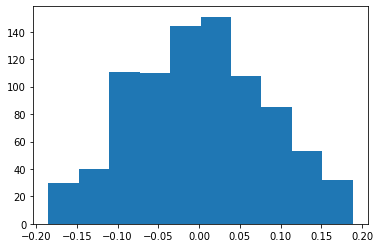

In [52]:
x = layers.Conv2D(32, kernel_size=3, strides=(2, 2), kernel_initializer=CONV_KERNEL_INIT)
get_layer_weights(x)

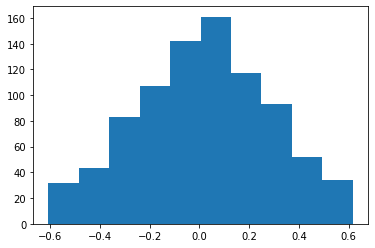

In [53]:
# He Normal is different
x = layers.Conv2D(32, kernel_size=3, strides=(2, 2), kernel_initializer=keras.initializers.he_normal())
get_layer_weights(x)

In [ ]:
def efficientnet(input_layer, phi, model_name, image_data_format="channels_last"):
    bn_axis = 3 if image_format=="channels_last" else 1
    # EfficientNet B0 Values (alpha = depth (num layers), beta = width (num filters), gamma = resolution)
    alpha, beta, gamma = 1.2, 1.1, 1.15
    detpth_coeff, width_coeff, res_coeff = alpha**phi, beta**phi, gamma**phi
    # Create Stem
    x = layers.Conv2D(round_num_filters(32, width_coeff), kernel_size=3, strides=(2, 2), padding="same", use_bias=False, kernel_initializer=CONV_KERNEL_INIT, name="stem_conv")(input_layer)
    x = layers.BatchNormalization()

In [ ]:
    return EfficientNet(1.0, 1.0, 224, 0.2,
                        model_name='efficientnet-b0',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)